# WRDS, CRSP, and Compustat

This chapter shows how to connect to [Wharton Research Data Services (WRDS)](https://wrds-www.wharton.upenn.edu/), a popular provider of financial and economic data for research applications. We use this connection to download the most commonly used data for stock and firm characteristics, CRSP and Compustat. Unfortunately, this data is not freely available, but most students and research typically have access to WRDS through their libraries. Assuming that you have access to WRDS, we show you how to prepare and merge the databases and store them in the `SQLite`-database introduced in the previous chapter. We conclude this chapter by providing some tips for working the WRDS database. 

## Downloading and preparing CRSP

We use the three remote tables to fetch the data we want to put into our local database. Just as above, the idea is that we let the WRDS database do all the work and just download the data that we actually need. We apply common filters and data selection criteria to narrow down our data of interest: (i) we keep only data in the time windows of interest, (ii) we keep only US-listed stocks as identified via share codes 10 and 11, and (iii) we keep only months with valid permno-specific information from `msenames`. In addition, we add delisting reasons and returns. You can read up in the great textbook of [BaliEngleMurray2016](https://doi.org/10.1002/9781118445112.stat07954) (BEM) for an extensive discussion on the filters we apply in the code below.

In [32]:
import pandas as pd
crsp_monthly=pd.read_csv("D:/Tidy/crsp_monthly.csv")

In [33]:
crsp_monthly['month']=pd.to_datetime(crsp_monthly['month'])

The first additional variable we create is market capitalization (`mktcap`). Note that we keep market cap in millions of USD just for convenience (we do not want to print huge numbers in our figures and tables). Moreover, we set zero market cap to missing as it makes conceptually little sense (i.e., the firm would be bankrupt).

In [34]:
crsp_monthly=crsp_monthly.sort_values(by=['permno','month'])

In [35]:
import numpy as np
crsp_monthly['mktcap']=np.abs(crsp_monthly['shrout'] * crsp_monthly['altprc']) / 1000000

In [36]:
crsp_monthly['mktcap']=crsp_monthly['mktcap'].fillna(0)

In [37]:
crsp_monthly.exchcd.describe()

count    3.327423e+06
mean     2.216997e+00
std      1.023916e+00
min     -2.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      3.000000e+00
max      3.300000e+01
Name: exchcd, dtype: float64

In [38]:
nno=crsp_monthly.loc[crsp_monthly.mktcap==0]

The next variable we frequently use is the one-month *lagged* market capitalization. Lagged market capitalization is typically used to compute value-weighted portfolio returns, as we demonstrate in a later chapter. The most simple and consistent way to add a column with lagged market cap values is to add one month to each observation and then join the information to our monthly CRSP data.

The next variable we frequently use is the one-month *lagged* market capitalization. Lagged market capitalization is typically used to compute value-weighted portfolio returns, as we demonstrate in a later chapter. The most simple and consistent way to add a column with lagged market cap values is to add one month to each observation and then join the information to our monthly CRSP data. 

In [39]:
mktcap_lag=pd.DataFrame(
    {
        'permno':crsp_monthly['permno'],
        'month' :crsp_monthly['month'],
        'mktcap_lag':crsp_monthly['mktcap']
    }
)

In [40]:
mktcap_lag=mktcap_lag.sort_values(by=['permno','month'])

In [41]:
mktcap_lag['month']= mktcap_lag.month + pd.DateOffset(months=1)

In [42]:
crsp_monthly=pd.merge(mktcap_lag,crsp_monthly,left_on=["permno",'month'],right_on=["permno",'month'],how='right')

In [43]:
crsp_monthly.loc[(crsp_monthly.mktcap_lag==0) & (crsp_monthly.mktcap!=0) & (crsp_monthly.ret != float('nan'))]

,permno,month,mktcap_lag,date,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd,mktcap
1236,10007,1989-02-01,0.0,1989-02-28,NaN,4380000.0,-2.1250,3,7370,NaN,NaN,9.307500
1720,10012,1987-10-01,0.0,1987-10-30,NaN,4328000.0,-0.6250,3,3670,NaN,NaN,2.705000
2813,10021,1986-03-01,0.0,1986-03-31,-0.017241,2600000.0,-3.5625,3,7940,NaN,NaN,9.262500
4178,10028,2012-11-01,0.0,2012-11-30,-0.246524,12176000.0,5.6360,2,5094,NaN,NaN,68.623938
7485,10051,2018-09-01,0.0,2018-09-28,NaN,36799000.0,20.8300,1,8093,NaN,NaN,766.523167
...,...,...,...,...,...,...,...,...,...,...,...,...
3313671,93047,2011-06-01,0.0,2011-06-30,-0.219355,27791000.0,4.8400,3,7389,NaN,NaN,134.508444
3313754,93048,2013-06-01,0.0,2013-06-28,-0.042934,50685000.0,5.3500,3,7299,NaN,NaN,271.164745
3314690,93076,1986-11-01,0.0,1986-11-28,NaN,11291000.0,-0.9375,3,3070,NaN,NaN,10.585313
3320974,93263,2017-05-01,0.0,2017-05-31,NaN,44102000.0,4.0700,3,1000,NaN,NaN,179.495148


Next, we follow BEM in transforming listing exchange codes to explicit exchange names.

In [44]:
crsp_monthly.loc[ (crsp_monthly.exchcd == 3)| (crsp_monthly.exchcd == 33), 'exchange'] = 'NASDAQ'
crsp_monthly.loc[ (crsp_monthly.exchcd == 2)| (crsp_monthly.exchcd == 32), 'exchange'] = 'AMEX'
crsp_monthly.loc[ (crsp_monthly.exchcd == 1)| (crsp_monthly.exchcd == 31), 'exchange'] = 'NYSE'
crsp_monthly['exchange']=crsp_monthly.exchange.fillna('Other')

In [45]:
crsp_monthly.loc[ (crsp_monthly.siccd >= 1) & (crsp_monthly.siccd <= 999), 'industry'] = 'Agriculture'
crsp_monthly.loc[ (crsp_monthly.siccd >= 1000) & (crsp_monthly.siccd <= 1499), 'industry'] = 'Mining'
crsp_monthly.loc[ (crsp_monthly.siccd >= 1500) & (crsp_monthly.siccd <= 1799), 'industry'] = 'Construction'
crsp_monthly.loc[ (crsp_monthly.siccd >= 2000) & (crsp_monthly.siccd <= 3999), 'industry'] = 'Manufacturing'
crsp_monthly.loc[ (crsp_monthly.siccd >= 4000) & (crsp_monthly.siccd <= 4899), 'industry'] = 'Transportation'
crsp_monthly.loc[ (crsp_monthly.siccd >= 4900) & (crsp_monthly.siccd <= 4999), 'industry'] = 'Utilities'
crsp_monthly.loc[ (crsp_monthly.siccd >= 5000) & (crsp_monthly.siccd <= 5199), 'industry'] = 'Wholesale'
crsp_monthly.loc[ (crsp_monthly.siccd >= 5200) & (crsp_monthly.siccd <= 5999), 'industry'] = 'Retail'
crsp_monthly.loc[ (crsp_monthly.siccd >= 6000) & (crsp_monthly.siccd <= 6799), 'industry'] = 'Finance'
crsp_monthly.loc[ (crsp_monthly.siccd >= 7000) & (crsp_monthly.siccd <= 8999), 'industry'] = 'Services'
crsp_monthly.loc[ (crsp_monthly.siccd >= 9000) & (crsp_monthly.siccd <= 9999), 'industry'] = 'Public'
crsp_monthly['industry']=crsp_monthly.industry.fillna('Missing')

In [46]:
crsp_monthly.isnull().sum()

permno              0
month               0
mktcap_lag      24999
date                0
ret            100541
shrout              2
altprc          70931
exchcd              0
siccd               0
dlret         3324932
dlstcd        3324815
mktcap              0
exchange            0
industry            0
dtype: int64

We also construct returns adjusted for delistings as described by BEM. After this transformation, we can drop the delisting returns and codes.

In [47]:
crsp_monthly.loc[ crsp_monthly.dlstcd.isnull(), 'ret_adj'] = crsp_monthly.ret

In [48]:
crsp_monthly.loc[ (crsp_monthly.dlstcd.notnull()) & (crsp_monthly.dlret.notnull()), 'ret_adj'] = crsp_monthly.dlret

In [49]:
crsp_monthly.loc[ (crsp_monthly.dlstcd >= 551) & (crsp_monthly.dlstcd <= 574), 'ret_adj'] = -0.30

In [50]:
crsp_monthly.loc[ (crsp_monthly.dlstcd == 500) | (crsp_monthly.dlstcd == 520) | (crsp_monthly.dlstcd == 580) | (crsp_monthly.dlstcd == 584), 'ret_adj'] = -0.30

In [51]:
crsp_monthly.loc[ (crsp_monthly.dlstcd == 100) , 'ret_adj'] = crsp_monthly.ret

In [52]:
crsp_monthly.loc[ ~((crsp_monthly.dlstcd.isnull()) | ((crsp_monthly.dlstcd.notnull()) & (crsp_monthly.dlret.notnull())) | ((crsp_monthly.dlstcd >= 551) & (crsp_monthly.dlstcd <= 574))|
                   ((crsp_monthly.dlstcd == 500) | (crsp_monthly.dlstcd == 520) | (crsp_monthly.dlstcd == 580) | (crsp_monthly.dlstcd == 584)) | (crsp_monthly.dlstcd == 100)), 'ret_adj' ]=-1

Next, we compute excess returns by subtracting the monthly risk-free rate provided by our Fama-French data. As we base all our analyses on the excess returns, we can drop adjusted returns and the risk-free rate from our tibble. Note that we ensure that excess returns are bounded by -1 from below as less than -100% return make conceptually no sense. Before we can adjust the returns, we have to connect to our database and load the tibble `factors_ff_monthly`.

In [53]:
import sqlite3
tidy_finance = sqlite3.connect("D:/Tidy/tidyfinance.sqlite")
factors_ff_monthly = pd.read_sql_query("SELECT * from factors_ff_monthly", tidy_finance)

In [54]:
factors_ff_monthly['month']=pd.to_datetime(factors_ff_monthly['month'])

In [55]:
factors_ff_monthly=factors_ff_monthly[['month','rf']]

In [56]:
crsp_monthly=pd.merge(factors_ff_monthly,crsp_monthly,left_on=['month'],right_on=['month'])

In [57]:
crsp_monthly['ret_excess']=crsp_monthly['ret_adj']-crsp_monthly['rf']

In [58]:
crsp_monthly.loc[crsp_monthly.ret_excess < -1,'ret_excess'] = -1

In [59]:
crsp_monthly=crsp_monthly.dropna(subset = ['ret_excess','mktcap','mktcap_lag'])
crsp_monthly=crsp_monthly.loc[crsp_monthly.mktcap_lag!=0]

In [60]:
crsp_monthly=crsp_monthly.sort_values(by=['permno','month'])

Since excess returns and market capitalization are crucial for all our analyses, we can safely exclude all observations with missing returns or market capitalization. 

In [61]:
crsp_monthly=crsp_monthly.drop(['dlstcd','dlret'],axis=1)

In [ ]:
import sqlite3
tidy_finance = sqlite3.connect('D:/Tidy/tidyfinance.sqlite')
crsp_monthly.to_sql('crsp_monthly',tidy_finance)

## First glimpse of the CRSP sample

Before we move on to other data sources, let us look at some descriptive statistics of the CRSP sample, which is our main source for stock returns. 

The figure below shows the monthly number of securities by listing exchange over time. NYSE has the longest history in the data, but NASDAQ exhibits a considerable large number of stocks. The number of stocks on AMEX is decreasing steadily over the last couple of decades. By the end of 2020, there are 2300 stocks on NASDAQ, 1244 on NYSE, 147 on AMEX and only 1 belongs to the other category.

In [62]:
exchange_count=crsp_monthly.groupby(['month','exchange']).permno.count().reset_index()

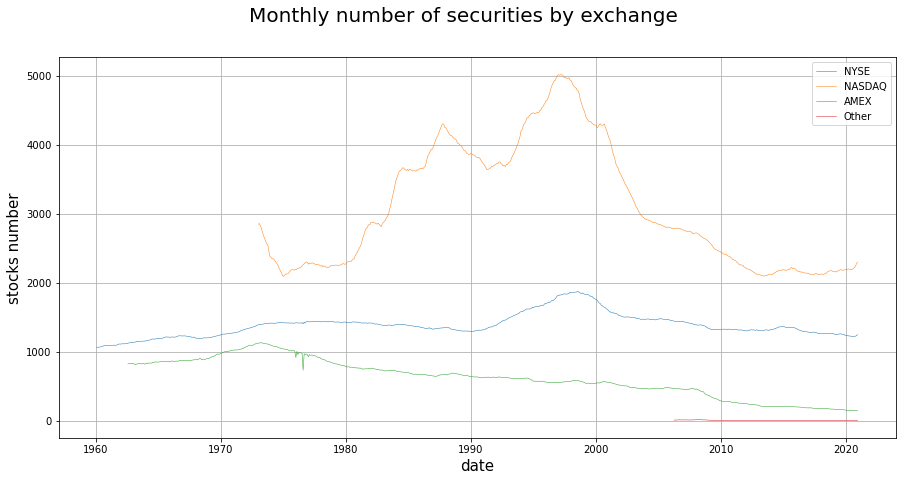

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
for ind in ['NYSE','NASDAQ','AMEX','Other']:
    ax.plot(exchange_count.loc[exchange_count.exchange == ind ]['month'], exchange_count.loc[exchange_count.exchange == ind ]['permno'], linewidth=0.5,label=ind)
fig.suptitle('Monthly number of securities by exchange',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('stocks number',fontsize=15)
ax.legend()
ax.grid()
plt.show()


Next, we look at the aggregate market capitalization of the respective listing exchanges. To ensure that we look at meaningful data which is comparable over time, we adjust the nominal values for inflation. In fact, we can use the tables that are already in our database to calculate aggregate market caps by listing exchange and plotting it just as if it were in memory. All values are in end of year(end_date) USD to ensure inter-temporal comparability. NYSE-listed stocks have by far the largest market capitalization, followed by NASDAQ-listed stocks.

Of course, performing the computation in the database is not really meaningful because we can easily pull all the required data into our memory. The code chunk above is slower than performing the same steps on tables that are already in memory. However, we just want to illustrate that you can perform many things in the database before loading the data into your memory. Before we proceed, we load the monthly CPI data. 

In [65]:
cpi_monthly = pd.read_sql_query("SELECT * from cpi_monthly", tidy_finance)

In [66]:
cpi_monthly['month']=pd.to_datetime(cpi_monthly['month'])

In [67]:
cpi_crsp=pd.merge(crsp_monthly,cpi_monthly,left_on=['month'],right_on=['month'])

In [68]:
monthly_mkt_cap=cpi_crsp.groupby(['month','exchange']).apply(lambda x:x.mktcap.sum()/(x.cpi.sum()/x.cpi.count())).rename('totalcap').reset_index()


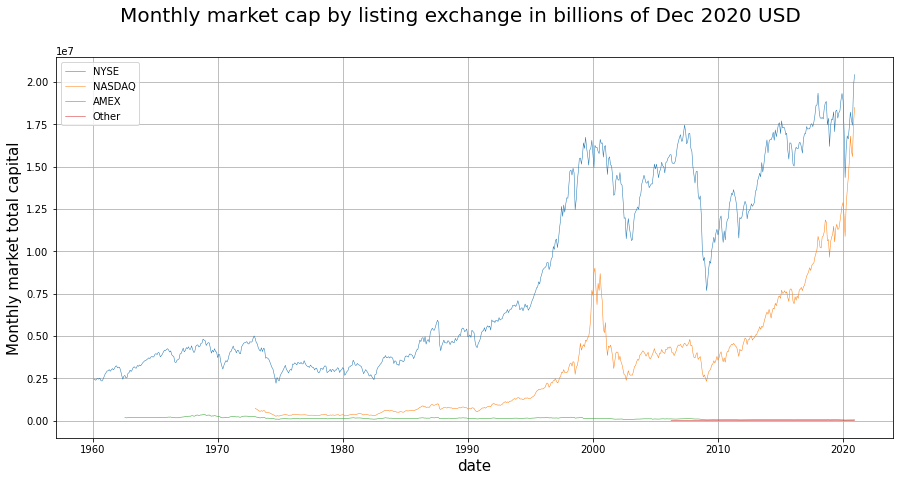

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
for ind in ['NYSE','NASDAQ','AMEX','Other']:
    ax.plot(monthly_mkt_cap.loc[monthly_mkt_cap.exchange == ind ]['month'], monthly_mkt_cap.loc[monthly_mkt_cap.exchange == ind ]['totalcap'], linewidth=0.5,label=ind)
fig.suptitle('Monthly market cap by listing exchange in billions of Dec 2020 USD',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('Monthly market total capital',fontsize=15)
ax.legend()
ax.grid()
plt.show()

Next, we look at the same descriptive statistics by industry. The figure below plots the number of stocks in the sample for each of the SIC industry classifiers. For most of the sample period, the largest share of stocks is apparently in Manufacturing, albeit the number peaked somewhere in the 90s. The number of firms associated with public administration seems to be the only category on the rise in recent years, even surpassing Manufacturing at the end of our sample period.

We also compute the market cap of all stocks belonging to the respective industries. All values are again in terms of billions of end of 2020 USD. At all points in time, manufacturing firms comprise of the largest portion of market capitalization. Towards the end of the sample, however, financial firms and services begin to make up a substantial portion of the market cap.

In [70]:
monthly_industry_count=cpi_crsp.groupby(['month','industry']).apply(lambda x:x.permno.count()).rename('count').reset_index()

In [71]:
indust=list(monthly_industry_count.industry.drop_duplicates().values)

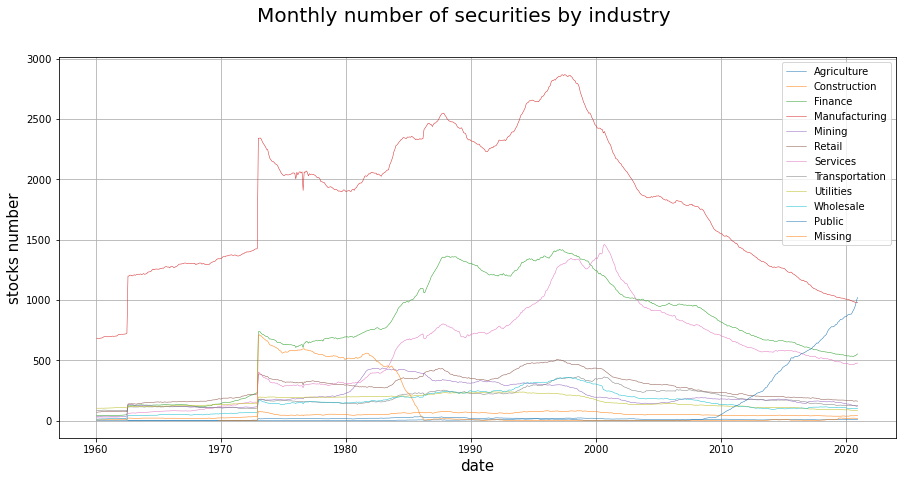

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
for ind in indust:
    ax.plot(monthly_industry_count.loc[monthly_industry_count.industry == ind ]['month'], monthly_industry_count.loc[monthly_industry_count.industry == ind ]['count'], linewidth=0.5,label=ind)
fig.suptitle('Monthly number of securities by industry',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('stocks number',fontsize=15)
ax.legend()
ax.grid()
plt.show()

In [73]:
monthly_industry_mktcap=cpi_crsp.groupby(['month','industry']).apply(lambda x:x.mktcap.sum()/(x.cpi.mean())).rename('indmktcap').reset_index()

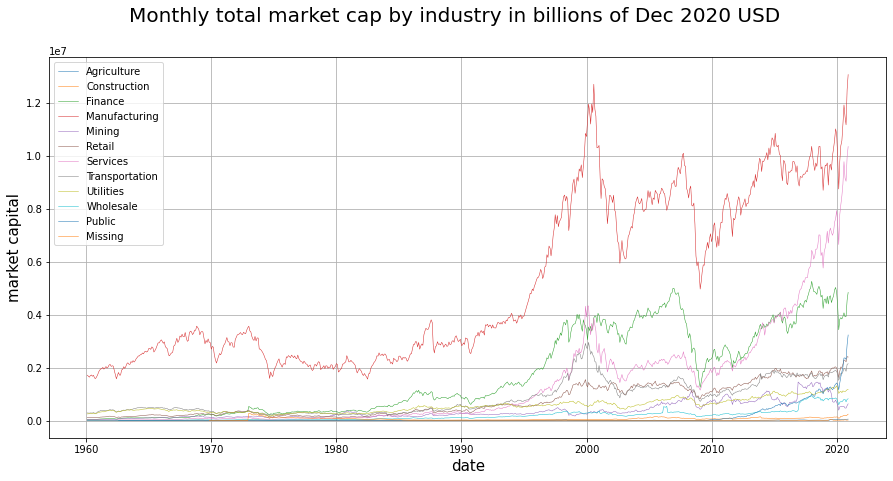

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
for ind in indust:
    ax.plot(monthly_industry_mktcap.loc[monthly_industry_mktcap.industry == ind ]['month'], monthly_industry_mktcap.loc[monthly_industry_mktcap.industry == ind ]['indmktcap'], linewidth=0.5,label=ind)
fig.suptitle('Monthly total market cap by industry in billions of Dec 2020 USD',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('market capital',fontsize=15)
ax.legend()
ax.grid()
plt.show()

## Preparing Compustat data

Firm accounting data are an important source of information that we use in portfolio analyses in subsequent chapters. The commonly used source for firm financial information is Compustat provided by [S&P Global Market Intelligence](https://www.spglobal.com/marketintelligence/en/), which is a global data vendor that provides financial, statistical, and market information on active and inactive companies throughout the world. For US and Canadian companies, annual history is available back to 1950 and quarterly as well as monthly histories date back to 1962.

To access Compustat data, we can again tap WRDS, which hosts the `funda` table that contains annual firm-level information on North American companies.

We follow the typical filter conventions and pull only data that we actually need: (i) we get only industrial fundamental data (i.e., ignore financial services) (ii) in the standard format (i.e., consolidated information in standard presentation), and (iii) only data in the desired time window.

In [149]:
compustat=pd.read_csv('D:/Tidy/compustat.csv')
compustat['datadate']=pd.to_datetime(compustat['datadate'])

Next, we calculate the book value of preferred stock and equity inspired by the [variable definition in Ken French's data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/variable_definitions.html). Note that we set negative or zero equity to missing as it makes conceptually little sense (i.e., the firm would be bankrupt).

In [150]:
compustat['be1']=np.nan
compustat['be1']=compustat.be1.fillna(compustat.seq).fillna(compustat.ceq + compustat.pstk).fillna(compustat['at'] + compustat['lt'])
compustat['be2']=np.nan
compustat['be2']=compustat.be2.fillna(compustat.txditc).fillna(compustat.txdb + compustat.itcb).fillna(0)
compustat['be3']=np.nan
compustat['be3']=compustat.be3.fillna(compustat.pstkrv).fillna(compustat.pstkl).fillna(compustat.pstk).fillna(0)
compustat['be']=compustat['be1']+compustat['be2']-compustat['be3']
compustat.loc[compustat.be <= 0,'be']=np.nan
compustat=compustat.drop(['be1','be2','be3'],axis=1)

We keep only the last available information for each firm-year group. Note that `datadate` defines the time the corresponding financial data refers to (e.g., annual report as of December 31, 2020). Therefore, `datadate` is not the date when data was made available to the public. Check out the exercises for more insights into the peculiarities of `datadate`.

In [151]:
compustat['year']=compustat['datadate'].apply(lambda x:x.year)

In [155]:
compustat_datatime_max=compustat.groupby(['gvkey','year']).apply(lambda x:x.datadate.max()).rename('datatime_max').reset_index()

In [156]:
compustat=pd.merge(compustat_datatime_max,compustat,left_on=['gvkey','datatime_max'],right_on=['gvkey','datadate'],how='left')

In [157]:
compustat=compustat.drop(['datatime_max','year_y'],axis=1)
compustat=compustat.rename(columns={'year_x':'year'})

In [141]:
compustat.to_sql('compustat',tidy_finance,if_exists='replace')

With the last step, we are already done preparing the firm fundamentals. Thus, we can store them in our local database. 

## Merging CRSP with Compustat

Unfortunately, CRSP and Compustat use different keys to identify stocks and firms. CRSP uses `permno` for stocks, while Compustat uses `gvkey` to identify firms. Fortunately, a curated matching table on WRDS allows us to merge CRSP and Compustat, so we create a connection to the *CRSP-Compustat Merged* table (provided by CRSP).

In [104]:
ccmxpf_linktable=pd.read_csv('D:/Tidy/ccmxpf_linktable.csv')

In [105]:
ccmxpf_linktable['linkdt']=pd.to_datetime(ccmxpf_linktable['linkdt'])
ccmxpf_linktable['linkenddt']=pd.to_datetime(ccmxpf_linktable['linkenddt'])

The linking table contains links between CRSP and Compustat identifiers from various approaches. However, we need to make sure that we keep only relevant and correct links, again following the description outlined in BEM.

In [110]:
ccm_links = pd.merge(crsp_monthly,ccmxpf_linktable,left_on=['permno'],right_on=['permno'],how='inner')

We use these links to create a new table with a mapping between stock identifier, firm identifier, and month. We then add these links to the Compustat `gvkey` to our monthly stock data. 

In [ ]:
ccm_links=ccm_links.dropna(subset = ['gvkey'])
ccm_links=ccm_links.loc[(ccm_links.date >= ccm_links.linkdt) & (ccm_links.date <= ccm_links.linkenddt)][['permno', 'gvkey', 'date']]

In [113]:
crsp_monthly=pd.merge(crsp_monthly,ccm_links,left_on=["permno", "date"],right_on=["permno", "date"],how='left')

As the last step, we update the previously prepared monthly CRSP file with the linking information in our local database.

In [114]:
crsp_monthly.to_sql('crsp_monthly',tidy_finance,if_exists='replace' )

Before we close this chapter, let us look at an interesting descriptive statistic of our data. As the book value of equity plays a crucial role in many asset pricing applications, it is interesting to know for how many of our stocks this information is available. Hence, the figure below plots the share of securities with book equity values for each exchange. It turns out that the coverage is pretty bad for AMEX- and NYSE-listed stocks in the 60s but hovers around 80% for all periods thereafter. We can ignore the erratic coverage of securities that belong to the other category since there is only a handful of them anyway in our sample.

In [118]:
crsp_monthly['year']=crsp_monthly.month.apply(lambda x :x.year)

In [158]:
crsp_date_max=crsp_monthly.groupby(['permno','year']).apply(lambda x:x.date.max()).rename('date_max').reset_index()
crsp_date_max=crsp_date_max.drop('year',axis=1)

In [159]:
crsp_monthly=pd.merge(crsp_date_max,crsp_monthly,left_on=['permno','date_max'],right_on=['permno','date'],how='left')

In [161]:
crsp_monthly=pd.merge(crsp_monthly,compustat,left_on=['gvkey','year'],right_on=['gvkey','year'],how='left')

In [166]:
coverage=crsp_monthly.groupby(['exchange','year']).apply(lambda x:x.be.notnull().sum()/x.permno.count()).rename('cov').reset_index()

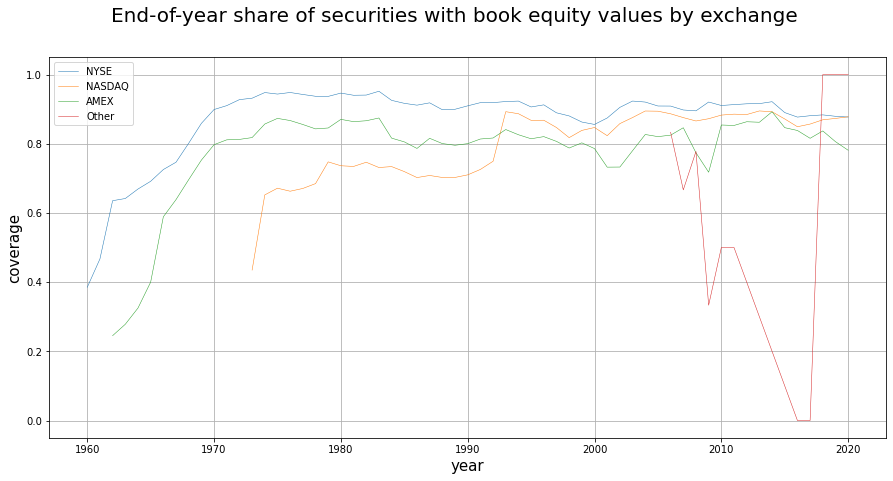

In [168]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
for ind in ['NYSE','NASDAQ','AMEX','Other']:
    ax.plot(coverage.loc[coverage.exchange == ind ]['year'], coverage.loc[coverage.exchange == ind ]['cov'], linewidth=0.5,label=ind)
fig.suptitle('End-of-year share of securities with book equity values by exchange',fontsize=20)
ax.set_xlabel('year',fontsize=15)
ax.set_ylabel('coverage',fontsize=15)
ax.legend()
ax.grid()
plt.show()